<center>

## ***Company-based Capstone Project***
#### **Team ID		: C24-MR01**

Team Member	: 

(ML) M002D4KY2877 - Auvarifqi Putra Diandra

(ML) M010D4KY3370 - Rafi Madani

(ML) M002D4KY2625 - Iskandar Muda Rizky Parlambang

(MD) A010D4KY4202 - Muhammad Adryan Haska Putra

(MD) A297D4KX4551 - Vena Feranica

(CC) C002D4KY1032 - Muhammad Naufal

(CC) C459D4KY0090 - Jamaludin Ahmad Rifai



---

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile

import tensorflow as tf
import keras
from keras import layers
from keras import ops

In [3]:
data_path = './data'
movies_ratings = pd.read_csv(f"{data_path}/ratings_small.csv")
movies_ratings.head(10)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [4]:
movies_ratings.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [5]:
movies_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
movies_ratings.shape

(100004, 4)

In [7]:
movies_ratings.dropna(inplace=True)

In [8]:
movies_ratings.shape

(100004, 4)

In [9]:
user_ids = movies_ratings["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = movies_ratings["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
movies_ratings["user"] = movies_ratings["userId"].map(user2user_encoded)
movies_ratings["movie"] = movies_ratings["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
movies_ratings["rating"] = movies_ratings["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(movies_ratings["rating"])
max_rating = max(movies_ratings["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)
print(movies_ratings)

Number of users: 671, Number of Movies: 9066, Min rating: 0.5, Max rating: 5.0
        userId  movieId  rating   timestamp  user  movie
0            1       31     2.5  1260759144     0      0
1            1     1029     3.0  1260759179     0      1
2            1     1061     3.0  1260759182     0      2
3            1     1129     2.0  1260759185     0      3
4            1     1172     4.0  1260759205     0      4
...        ...      ...     ...         ...   ...    ...
99999      671     6268     2.5  1065579370   670   7005
100000     671     6269     4.0  1065149201   670   4771
100001     671     6365     4.0  1070940363   670   1329
100002     671     6385     2.5  1070979663   670   1331
100003     671     6565     3.5  1074784724   670   2946

[100004 rows x 6 columns]


In [10]:
df = movies_ratings.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print(x, y)
print("Jumlah data train: ", len(x_train))
print("Jumlah data val: ", len(x_val))

[[ 127  165]
 [ 664 9064]
 [ 119 2763]
 ...
 [ 531 2199]
 [  11  346]
 [ 101   17]] [1.         0.11111111 0.55555556 ... 0.66666667 0.77777778 0.55555556]
Jumlah data train:  80003
Jumlah data val:  20001


In [11]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.build(input_shape=(None, 2))
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

model.summary()
print(f'Num users: {num_users}, Num movies: {num_movies}')
print(f'Embedding size: {EMBEDDING_SIZE}')
print(model.user_embedding)
print(model.movie_embedding)
print(model.user_bias)
print(model.movie_bias)

c:\Users\Iskandar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'recommender_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "recommender_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Num users: 671, Num movies: 9066
Embedding size: 50
<Embedding name=embedding, built=False>
<Embedding name=embedding_2, built=False>
<Embedding name=embedding_1, built=False>
<Embedding name=embedding_3, built=False>


In [12]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6577 - root_mean_squared_error: 0.2625 - val_loss: 0.6150 - val_root_mean_squared_error: 0.2205
Epoch 2/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6111 - root_mean_squared_error: 0.2172 - val_loss: 0.6119 - val_root_mean_squared_error: 0.2169
Epoch 3/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6027 - root_mean_squared_error: 0.2076 - val_loss: 0.6063 - val_root_mean_squared_error: 0.2114
Epoch 4/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6020 - root_mean_squared_error: 0.2071 - val_loss: 0.6070 - val_root_mean_squared_error: 0.2122
Epoch 5/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6005 - root_mean_squared_error: 0.2053 - val_loss: 0.6077 - val_root_mean_squared_error: 0.2130
Epoch 6/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6008 - root_mean_squared_error: 0.2062 - val_loss: 0.6083 - val_root_mean_squared_error: 0.2136
Epoch 7/10
1251/1251 ━━━━━━━━━━━━━━━━━━━

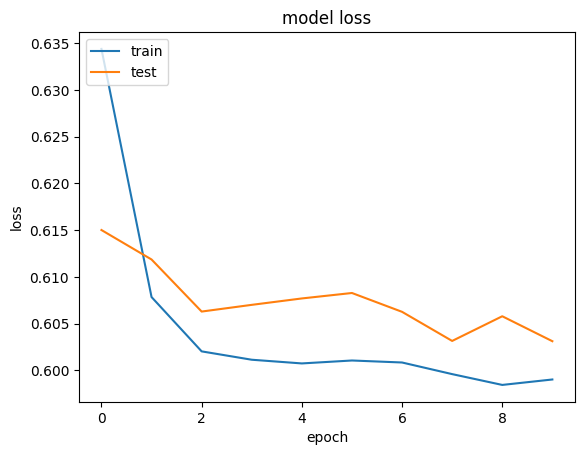

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [14]:
movie_df = movies_ratings[['movieId']].drop_duplicates()

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.movieId, ":", "row.genres")

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.movieId, ":", "row.genres")

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
Showing recommendations for user: 537
Movies with high ratings from user
--------------------------------
1356 : row.genres
1199 : row.genres
58 : row.genres
1124 : row.genres
938 : row.genres
--------------------------------
Top 10 movie recommendations
--------------------------------
858 : row.genres
1213 : row.genres
1221 : row.genres
1204 : row.genres
2692 : row.genres
1212 : row.genres
1217 : row.genres
1228 : row.genres
6016 : row.genres
2690 : row.genres
